# Abt Buy - Entity Matching using Neo4j

_Salomon Tetelepta, April 27th 2024_
* Notebook to explore entity matching using a graph representation of the Abt-Buy Dataset

* See how well we can perform on the [paperswithcode benchmark](https://paperswithcode.com/sota/entity-resolution-on-abt-buy).

* Datamodel:

```
    * (Item {id: source_id})-[:MATCH]->(Item {id: target_id})
    * (Item)-[:HAS_NAME]->(:Name {value: [original name]})
    * (Item)-[:HAS_DESCRIPTION]->(:Description)
    * (Name)-[:HAS_WORD]->(:Word {value: [preprocesed value], raw_value: [original_value]})
    * (Description)-[:HAS_WORD]->(:Word {value: [preprocesed value], raw_value: [original_value]})
    * (Item)-[:HAS_MANUFACTURER]->(:Manufacturer)
```

### Install dependencies

In [1]:
!pip install neo4j python-dotenv langchain-community --quiet

%load_ext watermark
%watermark -p neo4j

neo4j: 5.17.0



### Imports

In [14]:
from dotenv import load_dotenv, find_dotenv, dotenv_values
from langchain_community.graphs import Neo4jGraph
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_recall_fscore_support    
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from wordfreq import lossy_tokenize, tokenize, word_frequency

import json
import matplotlib.pyplot as plt
import neo4j
import numpy as np

import os
import pandas as pd
import pickle
import re

In [3]:
from utils import build_queries, build_match_queries

### Settings

In [4]:
# path settings
project_path = Path(os.getcwd()).parent
data_path = project_path / "data"
output_path = project_path / "output"

database = "abt-buy"

# load env settings
load_dotenv(project_path / ".env")

# reproducability
np.random.seed(42)

### 1. Load Data

In [5]:
os.listdir(data_path / 'abt-buy' / 'record_descriptions')

['2_buy.csv', '1_abt.csv']

In [6]:
# abt and buy records
df_abt = pd.read_csv(data_path / 'abt-buy' / 'record_descriptions' / '1_abt.csv', encoding='unicode_escape')
df_buy = pd.read_csv(data_path / 'abt-buy' / 'record_descriptions' / '2_buy.csv')

# matches - train and validation set
df_train = pd.read_csv(data_path / 'abt-buy' / 'gs_train.csv')
df_val = pd.read_csv(data_path / 'abt-buy' / 'gs_val.csv')
df_test = pd.read_csv(data_path / 'abt-buy' / 'gs_test.csv')

# merge records with matches
df_abt_merged = df_abt.merge(df_train, left_on='subject_id', right_on='source_id', how='right')
df_train_merged = df_buy.merge(df_abt_merged, left_on='subject_id', right_on='target_id', how='right')

df_train_merged.head(3)

,subject_id_x,name_x,description_x,manufacturer,price_x,subject_id_y,name_y,description_y,price_y,source_id,target_id,matching
0,207390654,Sony Handycam HDR-SR10 High Definition Digital...,16:9 - 2.7' Hybrid LCD,Sony,549.0,33161,Sony High Definition HDV Handycam Camcorder - ...,Sony High Definition HDV Handycam Camcorder - ...,NaN,33161,207390654,False
1,208085180,Pioneer DEH-2000MP Car Audio Player,"CD-RW - CD-Text, MP3, WMA, WAV - LCD - 4 - 200...",Pioneer,84.0,36258,D-Link Broadband Cable Modem - DCM202,D-Link Broadband Cable Modem - DCM202/ DOCSIS ...,79.00,36258,208085180,False
2,90125786,Sanus Wall/Ceiling Speaker Mount - WMS3S SILVER,Plastic - 8 lb,Sanus,NaN,17417,Sanus 13' - 30' VisionMount Flat Panel TV Silv...,Sanus 13' - 30' VisionMount Flat Panel TV Silv...,39.99,17417,90125786,False


### Create graph

In [7]:
# connect to Neo4j
graph = Neo4jGraph(
    url=os.getenv('NEO4J_URL'),
    username=os.getenv('NEO4J_USER'),
    password=os.getenv('NEO4J_PASS')
)

# create database if does not exist
graph._database = "system"
query = f"CREATE DATABASE `{database}` IF NOT EXISTS"
graph.query(query)

# change to target database
graph._database = database
print("database:", graph._database)

# check nr nodes in the graph
graph.query("MATCH (n) RETURN count(n)")

database: abt-buy


[{'count(n)': 25884}]

#### Parse records - add to graph

In [8]:
%%time
# Wall time: 19min 2s

run_cell = False

if run_cell == True:
    delete_graph = True

    n = len(df_abt)
    if delete_graph == True:
        query = "MATCH (n) DETACH DELETE n"
        graph.query(query)

    for i, (idx, row) in enumerate(df_abt.head(n).iterrows()):
        if i % 250 == 0:
            print(f"- processing abt: {i}/{n}")
        queries = build_queries(row, source="abt")
        for query in queries:
            graph.query(query)
    print(f"{n} records for abt")

    n = len(df_buy)
    for i, (idx, row) in enumerate(df_buy.head(n).iterrows()):
        if i % 250 == 0:
            print(f"- processing buy: {i}/{n}")
        queries = build_queries(row, source="buy")
        for query in queries:
            graph.query(query)
    print(f"{n} records for buy")

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 11.9 µs


#### Run queries for matches

In [9]:
%%time
# Wall time: 1min 2s

run_cell = False

if run_cell == True:

    n = len(df_train)
    for i, (idx, row) in enumerate(df_train.head(n).iterrows()):
        if i % 500 == 0:
            print(f"- processing matches: {i}/{n}")

        queries = build_match_queries(row)
        for query in queries:
            graph.query(query)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 9.06 µs


#### Set degree feature for words

In [10]:
%%time

query = "MATCH p=(w:Word)<-[:HAS_WORD]-(n:Name) WITH w, count(n) AS name_degree SET w.name_degree = name_degree;"
graph.query(query)

query = "MATCH p=(w:Word)<-[:HAS_WORD]-(n:Description) WITH w, count(n) AS description_degree SET w.description_degree = description_degree;"
graph.query(query)

CPU times: user 4 ms, sys: 2.94 ms, total: 6.93 ms
Wall time: 111 ms


[]

#### Set display value for words

In [11]:
query = "MATCH (w:Word) SET w.display_value = w.value + ' (' + w.name_degree + ')' "
graph.query(query)

[]

### Examples from the graph

In [12]:
os.listdir(project_path / "images")

['2-example-similar-items.jpg', '1-example-match.jpg']

<h4>Example of Items that are a match </h4>
<img src="../images/1-example-match.jpg">
<hr>
<h4>Example of both matched and non-matched items that share multiple words</h4>
<img src="../images/2-example-similar-items.jpg">

### Evaluation

#### Baseline - random

In [37]:
results_baseline = []
for seed in np.arange(5):
    np.random.seed(seed)
    p = np.round(np.random.rand(len(df_test)))
    prec, recall, fscore, support = precision_recall_fscore_support(df_test['matching'], p, average='binary')

    results_baseline.append({'model': f'random_baseline_seed', 'threshold': None, 'prec': prec, 'recall': recall, 'fscore': fscore, 'evaluated_on': 'testset'})
df_results_baseline = pd.DataFrame(results_baseline).sort_values('fscore', ascending=False)
df_results_baseline 

,model,threshold,prec,recall,fscore,evaluated_on
0,random_baseline_seed,None,0.164265,0.522936,0.250000,testset
1,random_baseline_seed,None,0.158038,0.532110,0.243697,testset
3,random_baseline_seed,None,0.158960,0.504587,0.241758,testset
4,random_baseline_seed,None,0.147139,0.495413,0.226891,testset
2,random_baseline_seed,None,0.138138,0.422018,0.208145,testset


#### Model: Items share words with name degree below threshold

In [39]:
%%time

results = []

thresholds = np.concatenate([np.arange(8), np.arange(10, 20, 5), np.arange(20, 50, 10), np.arange(50, 150, 50)])[1:]
print("thresholds:", thresholds)

# Wall time: 29.3 s
for name_degree_threshold in thresholds:
    query = f"""
    MATCH p1=(i1:Item)-[:HAS_NAME]->(n1:Name)-[:HAS_WORD]->(w:Word)<-[:HAS_WORD]-(n2:Name)<-[:HAS_NAME]-(i2:Item)
    WHERE n1 <> n2
    AND w.name_degree < {name_degree_threshold}
    RETURN i1.subject_id, i2.subject_id"""
    df_p = pd.DataFrame(graph.query(query))

    if len(df_p) > 0:
    
        df_test_p = df_test.merge(df_p, left_on=['source_id', 'target_id'], right_on=['i1.subject_id', 'i2.subject_id'], how='left')
        df_test_p['p'] = df_test_p['i1.subject_id'] > 0

        prec, recall, fscore, support = precision_recall_fscore_support(df_test_p['matching'], df_test_p['p'], average='binary')

        results.append({'model': f'shared_word_threshold', 'threshold': name_degree_threshold, 'prec': prec, 'recall': recall, 'fscore': fscore, 'evaluated_on': 'testset'})
        
df_results = pd.DataFrame(results).sort_values('fscore', ascending=False).reset_index(drop=True)
df_results

thresholds: [  1   2   3   4   5   6   7  10  15  20  30  40  50 100]
CPU times: user 12 s, sys: 1.49 s, total: 13.5 s
Wall time: 19.7 s


,index,model,threshold,prec,recall,fscore,evaluated_on
0,3,shared_word_threshold,6,0.885714,0.664286,0.759184,testset
1,5,shared_word_threshold,10,0.754717,0.759494,0.757098,testset
2,4,shared_word_threshold,7,0.803150,0.698630,0.747253,testset
3,2,shared_word_threshold,5,0.902174,0.628788,0.741071,testset
4,6,shared_word_threshold,15,0.635193,0.826816,0.718447,testset
5,7,shared_word_threshold,20,0.576667,0.878173,0.696177,testset
6,1,shared_word_threshold,4,0.954545,0.520661,0.673797,testset
7,0,shared_word_threshold,3,1.000000,0.474138,0.643275,testset
8,8,shared_word_threshold,30,0.474537,0.915179,0.625000,testset
9,9,shared_word_threshold,40,0.387358,0.937255,0.548165,testset


In [49]:
df_results_all = pd.concat([df_results_baseline, df_results]).sort_values('fscore', ascending=False).reset_index(drop=True)
df_results_all.to_csv(output_path / "results.csv", index=False)

#### Visualize precision, recall and fscore for different thresholds

Best model:


,model,threshold,prec,recall,fscore,evaluated_on
0,shared_word_threshold,6,0.885714,0.664286,0.759184,testset


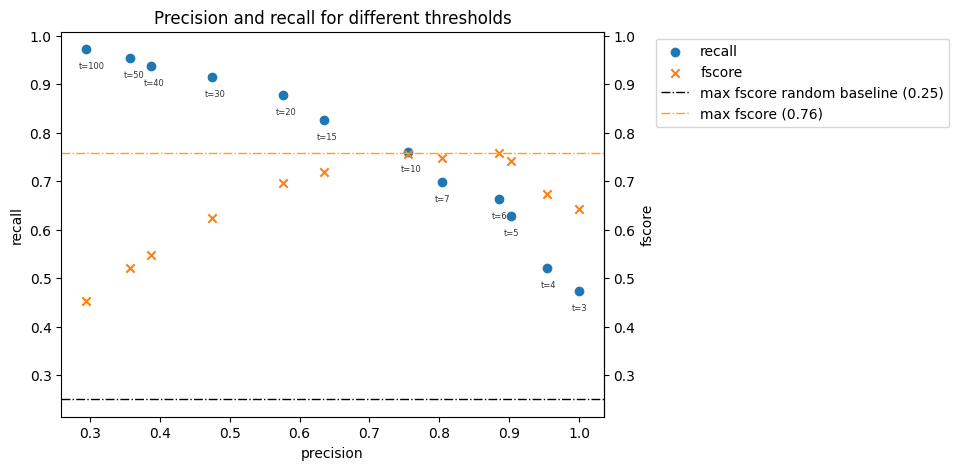

In [43]:
print("Best model:")
display(df_results.head(1))
x = df_results['prec']
y1 = df_results['recall']
y2 = df_results['fscore']
s = df_results['threshold']

plt.figure(figsize=(7, 5))
plt.title("Precision and recall for different thresholds")
plt.scatter(x, y1, label="recall", marker="o")
plt.scatter(x, y2, label="fscore", marker="x")
plt.xlabel("precision")
plt.ylabel("recall")
ax2 = plt.gca().secondary_yaxis('right')
ax2.set_ylabel("fscore")
for i, ss in enumerate(s.values):
    plt.text(x.values[i] - 0.01, y1.values[i] - 0.04, f"t={ss}", fontsize=6, alpha=0.8)

fmax_random = df_results_baseline['fscore'].max()
fmax_model = df_results['fscore'].max()

plt.axhline(fmax_random, label=f"max fscore random baseline ({fmax_random:.2f})", color="k", linestyle="-.", linewidth=1)
plt.axhline(fmax_model, label=f"max fscore ({fmax_model:.2f})", color="orange", linestyle="-.", linewidth=1)
plt.legend(loc="upper right", bbox_to_anchor=(1.65, 1))
plt.show()